In [1]:
import pandas as pd
import tensorflow as tf
from keras.preprocessing import text, sequence
import numpy as np
from keras.layers import Input, SpatialDropout1D,Dropout, GlobalAveragePooling1D, GlobalMaxPooling1D, \
                            CuDNNGRU, GRU, Bidirectional, LSTM, Dense, Embedding, concatenate, Embedding, \
                            Flatten, Activation, BatchNormalization, regularizers, Conv1D, Conv2D, MaxPooling2D
from keras.constraints import max_norm
from keras.losses import mean_squared_error
from keras.initializers import Orthogonal
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LambdaCallback, Callback, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
import keras.backend as K
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split
import os
import pickle
import gc; gc.enable()
import matplotlib 
import matplotlib.pyplot as plt
%matplotlib inline
import string
from scipy.stats import boxcox
import re
#from tqdm import tqdm

Using TensorFlow backend.


In [2]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
K.tensorflow_backend._get_available_gpus()

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8433681480677306766
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10644151911
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8012062308841069169
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


['/job:localhost/replica:0/task:0/device:GPU:0']

In [3]:
train = pd.read_pickle('data/train_original.pkl')
test = pd.read_pickle('data/test_original.pkl')
special_cols = [col for col in train.columns if train[col].dtype != np.float64]
feature_cols = [col for col in train.columns if col not in special_cols]

In [4]:
train.iloc[:10000,].corr('spearman')[['target']].sort_values('target', ascending=False)

,target
target,1.000000
var_26,0.064780
var_1,0.060204
var_53,0.056430
var_2,0.054718
var_67,0.053385
var_151,0.053148
var_190,0.052683
var_184,0.046785
var_18,0.046687


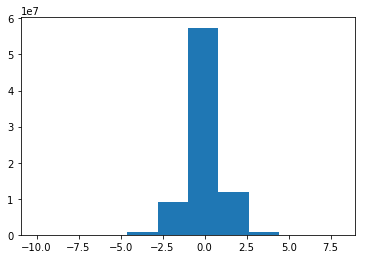

In [5]:
# normalize all values
all_values = pd.concat([train[feature_cols], test[feature_cols]], axis=0).values
all_values = (all_values-all_values.mean())/all_values.std()
plt.hist(all_values.flatten()); plt.show()

In [6]:
all_values.shape

(400000, 200)

In [7]:
def build_model(input_shape, drop_noise=0.1, start_size=30):
    
    f = Input(shape=[input_shape])
    main = Dropout(drop_noise)(f)
    main = Dense(start_size, activation='relu')(main)
    
    mid1_bottle_neck = Dense(start_size*3, activation='linear')(main)
    mid1 = Activation('relu')(mid1_bottle_neck)
    
    mid2_bottle_neck = Dense(start_size*3, activation='linear')(mid1)
    mid2 = Activation('relu')(mid2_bottle_neck)
    
    mid3_bottle_neck = Dense(start_size*3, activation='linear')(mid2)
    mid3 = Activation('relu')(mid3_bottle_neck)
    
    main = Dense(start_size, activation='relu')(mid3)
    out = Dense(input_shape, activation='linear')(main)
    
    model = Model(f, out)
    model.regularizers = [regularizers.l2(0.0001)]
    model.compile(optimizer = Adam(lr=0.002, clipnorm=5.), loss = 'mean_squared_error',
                  metrics =[mean_squared_error])
    
    #output_f = concatenate([mid2_bottle_neck])
    model_features = Model(f, mid2_bottle_neck)
    
    model.summary()
    return model, model_features

In [8]:
build_model(200)
K.clear_session()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 30)                6030      
_________________________________________________________________
dense_2 (Dense)              (None, 90)                2790      
_________________________________________________________________
activation_1 (Activation)    (None, 90)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 90)                8190      
_________________________________________________________________
activation_2 (Activation)    (None, 90)                0         
__________

In [9]:
import warnings; warnings.filterwarnings('ignore') 
from keras_tqdm import TQDMNotebookCallback
from ipywidgets import IntProgress

do_validation = False
version = 'v3'
model, model_features = build_model(train.shape[1]-2, drop_noise=0.1, start_size=150)


if do_validation:
    train_data = all_values[:320000]
    val_data = all_values[320000:]
    
    #lr_schd = LearningRateScheduler(lambda epoch: 0.001*(0.2**(epoch//5)), verbose=1)
    file_path = "dae_weights/dae_{}.hdf5".format(version)
    lr_schd = ReduceLROnPlateau(factor=0.1, patience=2, min_lr=0.00002, verbose=1)
    check_point = ModelCheckpoint(file_path, monitor = "val_loss", mode = "min", save_best_only = True, verbose = 1)
    early_stop = EarlyStopping(patience=4)
    history = model.fit(train_data, train_data,
                        validation_data=(val_data, val_data),
                        epochs=60,
                        verbose = 0, 
                        callbacks = [lr_schd, check_point, 
                                     early_stop, TQDMNotebookCallback(leave_inner=True, leave_outer=True)])
else:
    lrs = [0.002]*5 + [0.0002]*3 + [0.00002]*2
    file_path = "dae_weights/dae_{}_all.hdf5".format(version)

    lr_schd = LearningRateScheduler(lambda epoch: lrs[epoch], verbose=1)
    history = model.fit(all_values, all_values,
                        epochs=len(lrs),
                        verbose = 0, 
                        callbacks = [lr_schd, TQDMNotebookCallback(leave_inner=True, leave_outer=True)])
    model.save_weights(file_path)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 150)               30150     
_________________________________________________________________
dense_2 (Dense)              (None, 450)               67950     
_________________________________________________________________
activation_1 (Activation)    (None, 450)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 450)               202950    
_________________________________________________________________
activation_2 (Activation)    (None, 450)               0         
__________


Epoch 00001: LearningRateScheduler setting learning rate to 0.002.



Epoch 00002: LearningRateScheduler setting learning rate to 0.002.



Epoch 00003: LearningRateScheduler setting learning rate to 0.002.



Epoch 00004: LearningRateScheduler setting learning rate to 0.002.



Epoch 00005: LearningRateScheduler setting learning rate to 0.002.



Epoch 00006: LearningRateScheduler setting learning rate to 0.0002.



Epoch 00007: LearningRateScheduler setting learning rate to 0.0002.



Epoch 00008: LearningRateScheduler setting learning rate to 0.0002.



Epoch 00009: LearningRateScheduler setting learning rate to 2e-05.



Epoch 00010: LearningRateScheduler setting learning rate to 2e-05.


In [10]:
model.load_weights(file_path)
trn_sdae_features = model_features.predict(all_values[:train.shape[0]])
tst_sdae_features = model_features.predict(all_values[train.shape[0]:])

In [13]:
cols = ['sdae_{}'.format(i) for i in range(trn_sdae_features.shape[1])]
tmp = pd.DataFrame(data=trn_sdae_features, columns=cols)
tmp['target'] = train.target
tmp.iloc[:10000,].corr('spearman')[['target']].sort_values('target', ascending=False)

,target
target,1.000000
sdae_243,0.094648
sdae_378,0.093444
sdae_231,0.092638
sdae_319,0.091145
sdae_200,0.090089
sdae_94,0.086911
sdae_443,0.081098
sdae_49,0.080811
sdae_91,0.080015


In [14]:
pd.DataFrame(data=trn_sdae_features, columns=cols).to_pickle('features/sdae_{}_train.pkl'.format(version))
pd.DataFrame(data=tst_sdae_features, columns=cols).to_pickle('features/sdae_{}_test.pkl'.format(version))

In [12]:
tmp = pd.DataFrame(data=sdae_features, columns=['sdae_{}'.format(i) for i in range(sdae_features.shape[1])])
tmp['target'] = train.target
tmp.iloc[:10000,].corr('spearman')[['target']].sort_values('target', ascending=False)

,target
target,1.000000
sdae_253,0.100469
sdae_431,0.093971
sdae_212,0.083448
sdae_211,0.079514
sdae_114,0.078993
sdae_434,0.078547
sdae_129,0.077753
sdae_295,0.076304
sdae_57,0.072865


In [13]:
tmp = pd.DataFrame(data=sdae_features, columns=['sdae_{}'.format(i) for i in range(sdae_features.shape[1])])
tmp['target'] = train.target
tmp.iloc[:10000,].corr('spearman')[['target']].sort_values('target', ascending=False)

,target
target,1.000000
sdae_202,0.099082
sdae_205,0.076939
sdae_282,0.073063
sdae_146,0.064917
sdae_48,0.064293
sdae_170,0.064284
sdae_129,0.063674
sdae_250,0.062675
sdae_280,0.062163
